In [1]:
%%bash
git add my_toy_nn.ipynb

In [2]:
%matplotlib inline

https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe

#  準備

* 正解がゼロとイチであるような100個のデータを作る
* ゼロの方よりイチのほうがすべての座標の平均が1.5大きい

In [15]:

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

X1 = torch.randn(1000, 50)
X2 = torch.randn(1000, 50) + 1.5
X = torch.cat([X1, X2], dim=0)
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
Y = torch.cat([Y1, Y2], dim=0)
print(X.size())
print(Y.size())

torch.Size([2000, 50])
torch.Size([2000, 1])


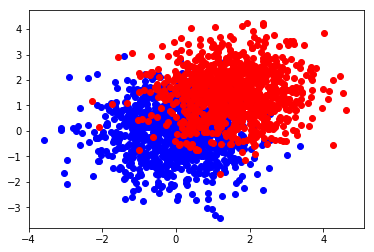

In [17]:

plt.scatter(X1[:, 0], X1[:, 2], color='b')
plt.scatter(X2[:, 0], X2[:, 2], color='r')

In [8]:
X1.shape

torch.Size([1000, 50])

In [14]:
Y1.shape

torch.Size([1000, 1])

# ネットワークの定義

##  線形変換＋sigmoid

In [20]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 1)
    #    self.relu1 = nn.ReLU()
     #   self.dout = nn.Dropout(0.2)
     #   self.fc2 = nn.Linear(50, 100)
      #  self.prelu = nn.PReLU(1)
      #  self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
   #     h1 = self.relu1(a1)
   #     dout = self.dout(h1)
   #     a2 = self.fc2(dout)
    #    h2 = self.prelu(a2)
    #    a3 = self.out(h2)
        y = self.out_act(a1)
        return y
    

In [18]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    

In [21]:
net = Net()

# optimizer

In [22]:
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

# Binary cross entropy

ふたつの確率分布$p,q$があったときクロスエントロピーは

$$
H(p,q) =-{\rm E}_p[\log(q)]
$$

で定義される

説明変数のsample 
$$
x_0,x_1,\cdots , x_{N-1}
$$
に対して、正解が１であり、NNが確率$z$で１であると出力したとき、
正解の確率分布は


$$
 p(x) =
 \begin{cases}
        1 & x = 1\\
        0 & x = 0
 \end{cases}
$$
NNの導いた確率分布は
$$
 q(x) =
 \begin{cases}
        z & x = 1\\
        1-z & x = 0
 \end{cases}
$$
なのでクロスエントロピーは
$$
H(p,q) = -\log(z)
$$
であるが、
$$
H(q,p) = -z \log(1) - (1-z) \log(0)
$$
は計算できない

In [ ]:
criterion = nn.BCELoss()

In [23]:
nn.BCELoss?